In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram


## 1. Preprocessing

1. Read the file [`regression.csv`](https://drive.google.com/file/d/1fzOPkuXoxLleOsvNVCT0m-LKxlid33ma/view?usp=sharing) to a dataframe.
2. Remove the `pageviews`, we will cluster the users only by the number of the commits and their average difference.

In [2]:
df = pd.read_csv('../data/regression.csv')
df = df.drop(['pageviews', 'uid'], axis=1)
df.head()


,num_commits,AVG(diff)
0,62,-64.400000
1,20,-74.800000
2,61,-159.000000
3,51,-61.600000
4,5,-5.666667


## 2. KMeans

1. Check the documentation about how this algorithm works.
2. Use this algorithm to create clusters, use `random_state=21` and `n_clusters=3`.
3. Visualize the data on a `scatter plot`.
4. Try different values of `n_clusters` and see how your plot will change.
5. Calculate the `silhouette_score` (check the docs about the metric).

0.48638087320227846

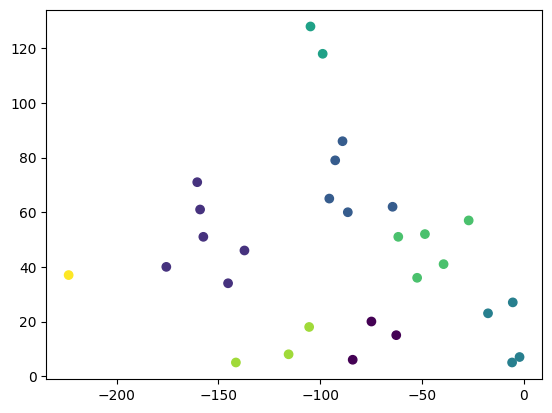

In [3]:
kmeans = KMeans(n_clusters=8, random_state=21).fit(df)
y_pred = kmeans.predict(df)
plt.scatter(df['AVG(diff)'], df['num_commits'], c=y_pred)
silhouette_score(df, y_pred)

## 3. DBSCAN

1. Check the documentation about how this algorithm works.
2. Use this algorithm to create clusters with `eps=20` and `min_samples=2`.
3. Visualize the data on a `scatter plot`.
4. Try different values of `eps` and `min_samples` and see how your plot will change.
5. Calculate the `silhouette_score` (check the docs about the metric).

0.38339641455696616

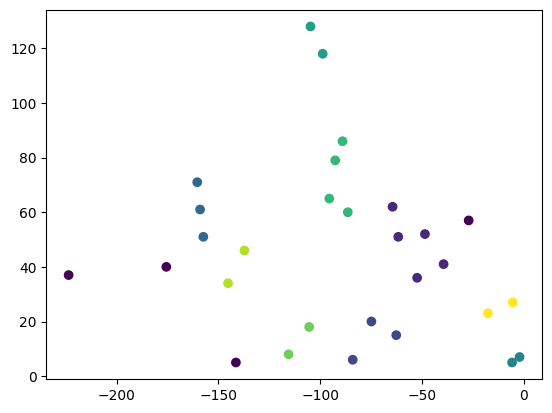

In [4]:
dbscan = DBSCAN(eps=20, min_samples=2).fit(df)
result = dbscan.labels_
plt.scatter(df['AVG(diff)'], df['num_commits'], c=dbscan.labels_)
silhouette_score(df, result)

-0.07923479818777455

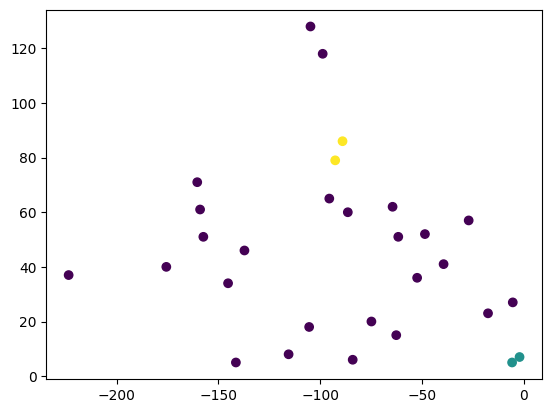

In [5]:
dbscan = DBSCAN(eps=10, min_samples=2).fit(df)
result = dbscan.labels_
plt.scatter(df['AVG(diff)'], df['num_commits'], c=dbscan.labels_)
silhouette_score(df, result)

0.4794129092034348

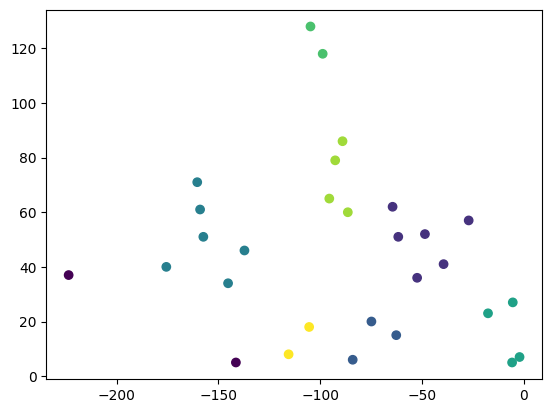

In [6]:
dbscan = DBSCAN(eps=22, min_samples=2).fit(df)
result = dbscan.labels_
plt.scatter(df['AVG(diff)'], df['num_commits'], c=dbscan.labels_)
silhouette_score(df, result)

## 4. Hierarchical (AgglomerativeClustering)

1. Use this algorithm to create clusters with `n_clusters=5`.
2. Visualize the data on a `scatter plot`.
3. Try different values of `n_clusters` and see how your plot will change.
4. Calculate the `silhouette_score`.
5. Visualize the `dendrogram`.

0.46383015199381467

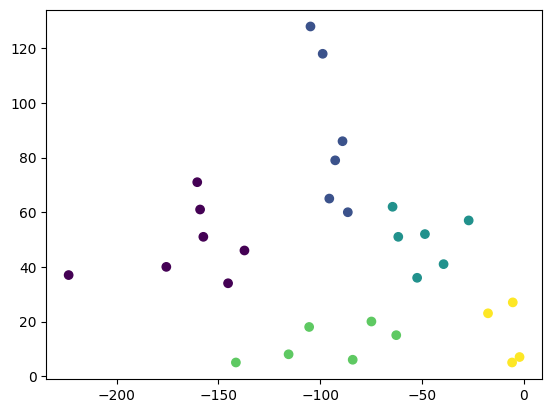

In [7]:
AggCl = AgglomerativeClustering(n_clusters=5).fit(df)
plt.scatter(df['AVG(diff)'], df['num_commits'], c=AggCl.labels_)
silhouette_score(df, AggCl.labels_)

0.4527145606287827

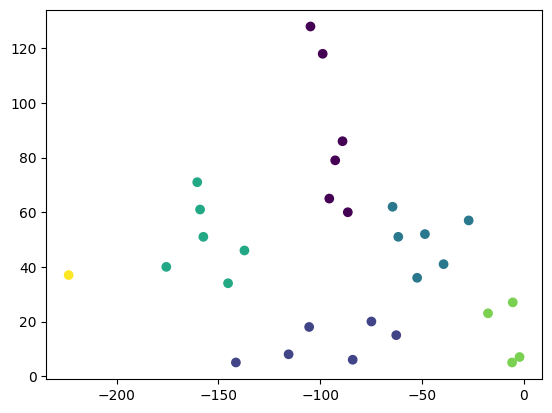

In [8]:
AggCl = AgglomerativeClustering(n_clusters=6).fit(df)
plt.scatter(df['AVG(diff)'], df['num_commits'], c=AggCl.labels_)
silhouette_score(df, AggCl.labels_)

0.4865808853184314

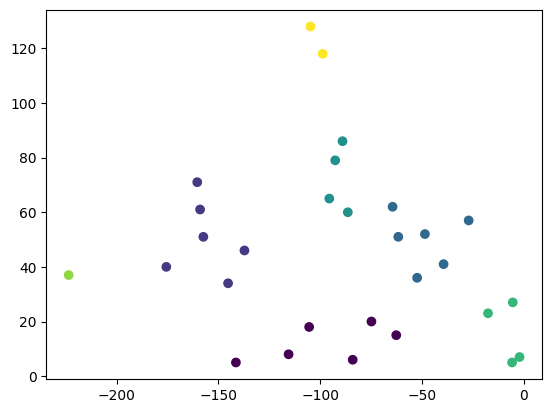

In [9]:
AggCl = AgglomerativeClustering(n_clusters=7).fit(df)
plt.scatter(df['AVG(diff)'], df['num_commits'], c=AggCl.labels_)
silhouette_score(df, AggCl.labels_)

0.50779855565622

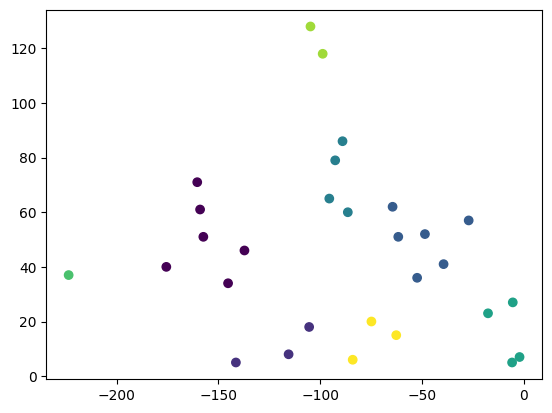

In [10]:
AggCl = AgglomerativeClustering(n_clusters=8).fit(df)
plt.scatter(df['AVG(diff)'], df['num_commits'], c=AggCl.labels_)
silhouette_score(df, AggCl.labels_)

In [11]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)

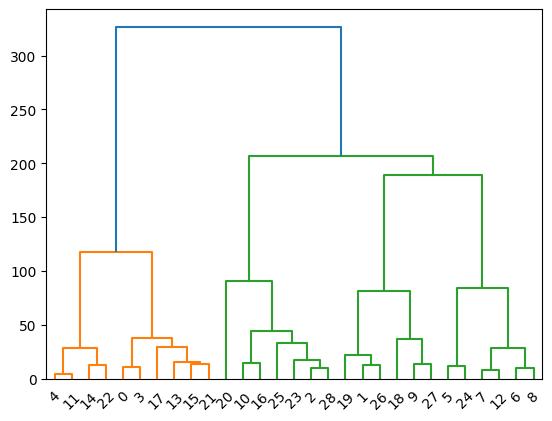

In [12]:
clustering = AgglomerativeClustering(distance_threshold=None, n_clusters=5, compute_distances=True).fit(df)
plot_dendrogram(clustering)

## 5. Function

Write a function that:
1. Takes as arguments: model class of clustering, its parameters, the name of the parameter for optimization, the range of the parameter values to try.
2. Tries different values from the given parameter range and calculates the `silhouette_score` for each value from the range.
3. Finds out the best value for the parameter in the range.
4. Returns two subplots:


- - the first shows how the `silhouette_score` changes depending on the value of the parameter,
- - the second visualizes the data on a `scatter plot` using the clustering model with the best value of the parameter.

In [15]:
def optimize_clustering_and_plot(
    model_class,
    fixed_params,
    param_name,
    param_values,
    X,
    xlabel='Feature 1',
    ylabel='Feature 2'
):
    scores = []
    all_labels = []

    for val in param_values:
        params = fixed_params.copy()
        params[param_name] = val

        try:
            model = model_class(**params)
            labels = model.fit_predict(X)
            all_labels.append(labels)
            unique_labels = set(labels)
            n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

            if n_clusters < 2:
                scores.append(np.nan)
            else:
                non_noise_mask = labels != -1
                if non_noise_mask.sum() < 2:
                    scores.append(np.nan)
                else:
                    unique_non_noise = np.unique(labels[non_noise_mask])
                    if len(unique_non_noise) < 2:
                        scores.append(np.nan)
                    else:
                        try:
                            score = silhouette_score(
                                X[non_noise_mask],
                                labels[non_noise_mask]
                            )
                            scores.append(score)
                        except:
                            scores.append(np.nan)
        except Exception as e:
            scores.append(np.nan)
            all_labels.append(np.full(X.shape[0], -2))  # placeholder

    scores = np.array(scores)
    
    if not np.any(~np.isnan(scores)):
        print(f"⚠️ Ни для одного значения {param_name} невозможно вычислить silhouette_score.")
        return None, None

    best_idx = np.nanargmax(scores)
    best_param = param_values[best_idx]
    best_score = scores[best_idx]
    best_labels = all_labels[best_idx]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(param_values, scores, 'o-', color='steelblue')
    ax1.set_xlabel(param_name)
    ax1.set_ylabel('Silhouette Score')
    ax1.set_title(f'{model_class.__name__}: Silhouette vs {param_name}')
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.axvline(best_param, color='red', linestyle='--', label=f'Best: {best_param}')
    ax1.legend()
    unique_labels = np.unique(best_labels)
    colors = plt.cm.tab10(np.linspace(0, 1, max(10, len(unique_labels))))

    for label, color in zip(unique_labels, colors):
        mask = best_labels == label
        if label == -1:
            ax2.scatter(X[mask, 0], X[mask, 1], c='k', label='Noise', edgecolors='k', s=60)
        else:
            ax2.scatter(X[mask, 0], X[mask, 1], c=[color], label=f'Cluster {label}', edgecolors='k', s=60)

    ax2.set_xlabel(xlabel)
    ax2.set_ylabel(ylabel)
    ax2.set_title(f'{model_class.__name__}: Best {param_name}={best_param}\nSilhouette={best_score:.3f}')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

    return best_param, best_score

=== DBSCAN ===


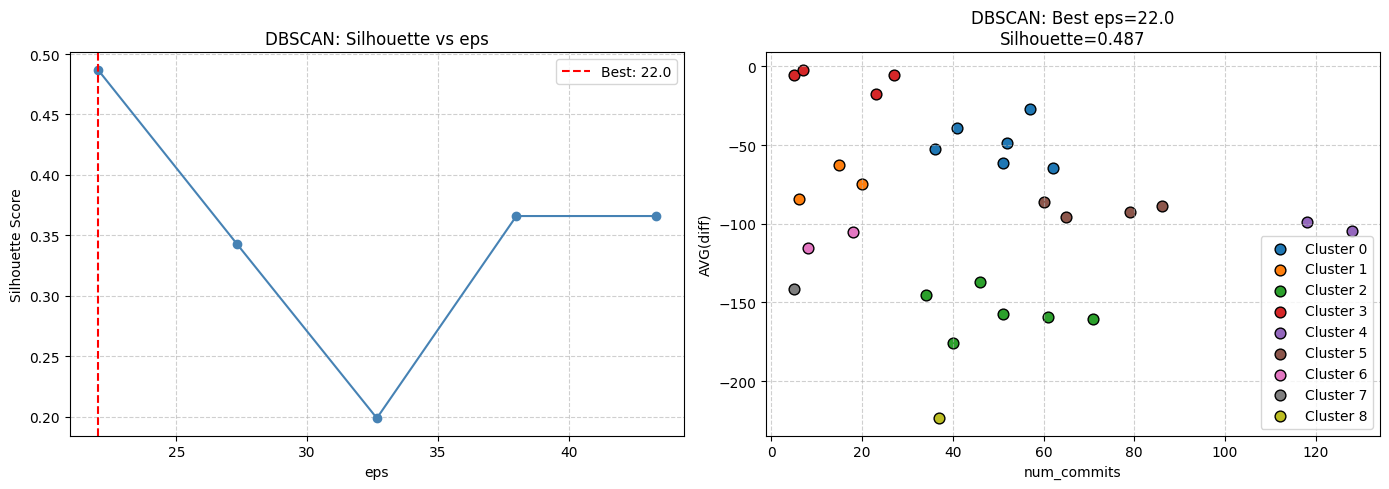


=== KMeans ===


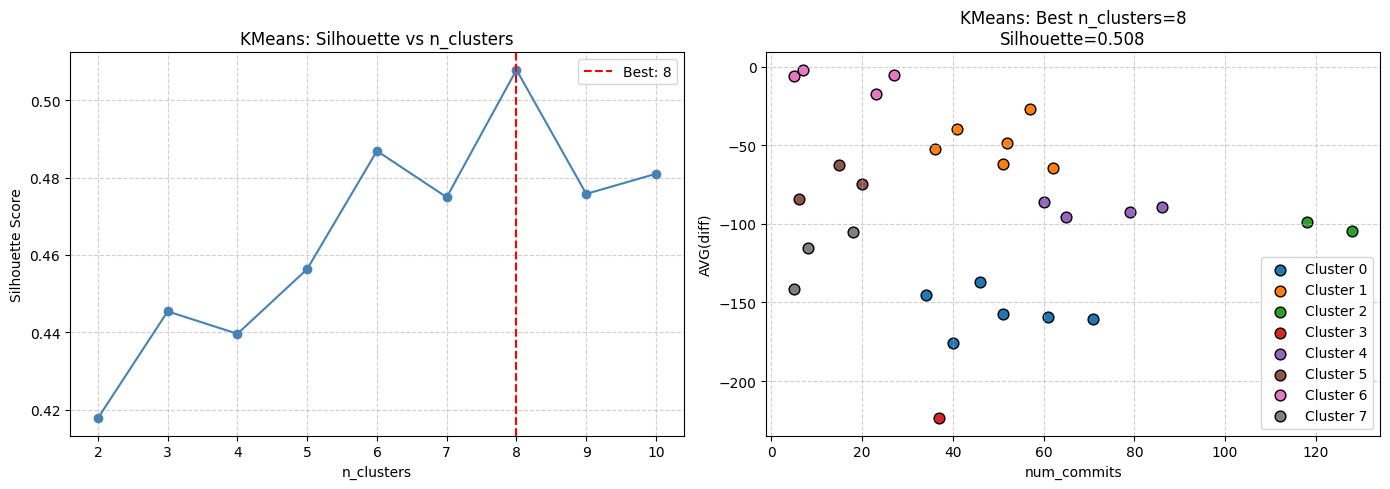


=== AgglomerativeClustering ===


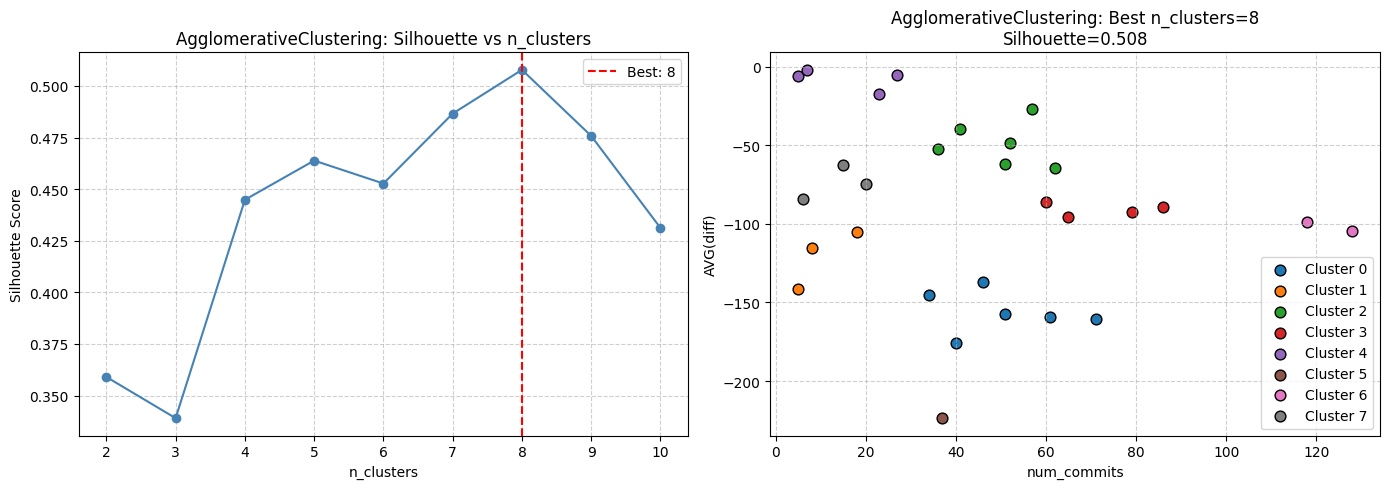

In [17]:
df = pd.read_csv('../data/regression.csv')
X = df[['num_commits', 'AVG(diff)']].values
xlabel, ylabel = 'num_commits', 'AVG(diff)'

print("=== DBSCAN ===")
best_eps, score_db = optimize_clustering_and_plot(
    model_class=DBSCAN,
    fixed_params={'min_samples': 1},
    param_name='eps',
    param_values=np.linspace(22, 150, 25),
    X=X,
    xlabel=xlabel,
    ylabel=ylabel
)

print("\n=== KMeans ===")
best_k, score_km = optimize_clustering_and_plot(
    model_class=KMeans,
    fixed_params={'random_state': 42},
    param_name='n_clusters',
    param_values=list(range(2, 11)),
    X=X,
    xlabel=xlabel,
    ylabel=ylabel
)

print("\n=== AgglomerativeClustering ===")
best_n, score_agg = optimize_clustering_and_plot(
    model_class=AgglomerativeClustering,
    fixed_params={'linkage': 'ward'},
    param_name='n_clusters',
    param_values=list(range(2, 11)),
    X=X,
    xlabel=xlabel,
    ylabel=ylabel
)